# Predicting Formula 1 Performance in Track and Weather Data 

**Group:** V10FTW  
**Members:** Oskar Floeck s3725028 & Connor Hutchinson s3544152

## Table of contents

* [Source and Description](#desc)
* [Goals and Objectives](#goals)
* [Data Preparation](#data)
* [Data Exploration](#explore)
* [Statistical Modelling & Performance Evaluation](#model)
* [Summary & Conclusion](#conc)

## Source and Description <a name="desc">

### Data Source

Formula 1 Raw Data: http://ergast.com/mrd (Ergast, 2020)  
Track Weather Data: https://www.motorsport-total.com/formel-1/ergebnisse (Motorsport-total, 2020)

Given the way in which weather data was provided by the website above, a script was written to automatically grab neccesary information and store within `track_weather.csv` for analysis in this report. The full script can be [viewed here](https://github.com/floeck/f1-weather-analysis/blob/master/notebooks/scrape-weather.ipynb).

* `races.csv` and `results.csv` obtained from Ergast: Contain all the relevant track data, such as fastest lap speeds, times and date.

* `track_weather.csv` from motorsport-total: Contain track weather information, such as humidity etc.

For the purposes of the report and due to track weather scraping limitations, the following tracks will be used in the analysis from the year 2007 to 2019. Details of these limitations are viewable on the script.

<table>
<tr>
</tr>
<tr>
<td>
    
* Albert Park, Australia
* Sepang, Malaysia
* Sachir, Bahrain
* Catalunya, Spain
* De Monaco, Europe 
* Montreal, Canada
* Magny Cours, France
* Silverstone, Britain
* Valencia, Germany
* Hungaroring, Hungary 
    
</td>
<td>
    
* Istanbul, Turkey
* Monza, Italy
* De Spa, Belgium
* Fuji, Japan
* Shanghai, China
* Interlagos, Brazil
* Yas Marina, Abu Dhabi
* Indianapolis, America
* Austin, America
* Hermanos, Mexico
    
</td>
</tr>
</table>

### Descriptive Features

Descriptions of data for `races.csv`

| feature | type  | units  | desc  |
|---|---|---|---|
| raceId  | ordinal | unknown | ID of the race |
| name | categorical | unknown  | Name of the race |
| date | date | yyyy-mm-dd | Date of race |

Descriptions of data for `results.csv`

| feature | type  | units  | desc  |
|---|---|---|---|
| raceId  | ordinal | unknown | ID of the race |
| fastestLapTime | positive real number | milliseconds  | Fastest lap time |
| fastestLapSpeed | positive real number | kph | Fastest average lap speed |

Descriptions of data for `track_weather.csv`

| feature | type  | units  | desc  |
|---|---|---|---|
| track  | categorical | unknown | Track name |
| date | date | yyyy-mm-dd | Date of race |
| local_time | time | hh:mm:ss | Time of race |
| weather | categorical | unknown | Track conditions |
| temp | positive real number | celcius | Ambient temp |
| track_temp | positive real number | celcius | Track temp |
| humidity | positive real number | % | Ambient humidity |
| air_pressure | positive real number | mBar | Ambient air pressure |
| wind_speed | positive real number | m/s | Track wind speed |
| wind_direction | categorical | direction | Track wind direction |


### Target Feature
The target feature is `fastestLapTime` which is a continuous numerical features.

## Goals and Objectives <a name="goals">

The primary goal of the report is to investigate whether or not we can accurately and reliably predict Formula 1 performance in the domain of fastest lap time via multiple linear regression, given the weather and track data we have collected.

## Data Preparation <a name="data">

### Preliminaries

First, import all necessary modules required for the analysis. A helper function `to_milliseconds` has been written to assist in converting lap times to milliseconds, so that they can be more appropriately analysed.

In [1]:
# Module imports
import warnings
import patsy
import pandas as pd 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from IPython.display import display_html, display, HTML

# Disable warnings and allow large columns
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# Function that allows to convert time
def to_milliseconds(string):
    string = string.replace(".", ":").split(":")
    minutes = int(string[0])
    seconds = int(string[1])
    milliseconds = int(string[2])
    return (minutes * 60000) + (seconds * 1000) + milliseconds

Here we read in the data directly from the repository site.

In [2]:
# Read in data to notebook
races = pd.read_csv('../data/formula-1/races.csv', sep=',')
results = pd.read_csv('../data/formula-1/results.csv', sep=',')
track_weather = pd.read_csv('../data/weather/track_weather.csv', sep=',')

# Or if running notebook outside repository...
#races = pd.read_csv('https://raw.githubusercontent.com/floeck/f1-weather-analysis/master/data/formula-1/races.csv', sep = ',')
#results = pd.read_csv('https://raw.githubusercontent.com/floeck/f1-weather-analysis/master/data/formula-1/results.csv', sep=',')
#track_weather = pd.read_csv('https://raw.githubusercontent.com/floeck/f1-weather-analysis/master/data/weather/track_weather.csv', sep=',')

Dataset: `races.csv`

In [3]:
races.sample(5, random_state=999)

,raceId,year,round,circuitId,name,date,time,url
685,686,1967,8,48,Canadian Grand Prix,1967-08-27,\N,http://en.wikipedia.org/wiki/1967_Canadian_Gra...
117,118,2003,11,9,British Grand Prix,2003-07-20,\N,http://en.wikipedia.org/wiki/2003_British_Gran...
160,161,2000,4,9,British Grand Prix,2000-04-23,\N,http://en.wikipedia.org/wiki/2000_British_Gran...
729,730,1962,2,6,Monaco Grand Prix,1962-06-03,\N,http://en.wikipedia.org/wiki/1962_Monaco_Grand...
94,95,2004,6,6,Monaco Grand Prix,2004-05-23,\N,http://en.wikipedia.org/wiki/2004_Monaco_Grand...


Dataset: `results.csv`

In [4]:
results.sample(5, random_state=999)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
20959,20962,848,5,205,20,19,19,19,19,0.0,55,\N,\N,44,19,1:45.055,185.697,12
24036,24042,1001,807,4,27,20,\N,R,20,0.0,0,\N,\N,\N,0,\N,\N,3
6593,6594,308,138,25,3,11,\N,R,20,0.0,35,\N,\N,\N,\N,\N,\N,20
5388,5389,266,50,22,6,12,3,3,3,4.0,77,+1:10.329,6550514,\N,\N,\N,\N,1
1691,1692,98,13,15,12,15,\N,R,18,0.0,0,\N,\N,\N,\N,\N,\N,4


Dataset: `track_weather.csv`

In [5]:
track_weather.sample(5, random_state=999)

,track,date,local_time,weather,temp,track_temp,humidity,air_pressure,wind_speed,wind_direction
96,austin,2012-11-18,13:00:00,sunny,24.0,32.0,29.0,1004.0,5.0,south
245,abu-dhabi,2018-11-25,17:10:00,"clear, short showers",29.0,31.0,55.0,1014.0,3.5,turning southeast
68,montreal,2010-06-13,12:00:00,slightly cloudy,26.0,38.0,42.0,1011.0,3.0,northeast
162,istanbul,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,indianapolis,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning and Transformation

Now that all the data is imported, we can begin cleaning and remove unneccesary information.

In [6]:
# Drop unneccesary columns
races = races.drop(columns = ['year', 'circuitId', 'round', 'time', 'url'])
results = results.drop(columns = ['resultId', 'driverId', 'constructorId', 'number', 'grid', 'position',
                                  'positionText', 'positionOrder', 'points', 'laps', 'fastestLap', 'time',
                                  'milliseconds', 'fastestLap', 'rank', 'statusId'])
track_weather = track_weather.drop(columns = 'local_time')

# Update problem data in columns
results = results.replace(r'\\N','null', regex=True)

# Query only those with races finishes
results = results.loc[results['fastestLapTime'] != 'null']

# Convert fastest lap speed to float
results['fastestLapSpeed'] = results['fastestLapSpeed'].astype(float)
results.rename(columns={'fastestLapSpeed': 'lapAverageSpeed', 'fastestLapTime': 'lapTime'}, inplace = True)

# Convert fastest time to milliseconds
results['lapTime'] = results['lapTime'].apply(to_milliseconds)

# Group by track and date, then average fastest lap and top speed
races_results = races.merge(results, on = 'raceId').groupby(['raceId', 'name', 'date']).mean()
df = races_results.merge(track_weather, on = 'date')

# Add rain column
rain_desc = ["rain", "shower", "drizzle", "wet"]
df['rain'] = np.where(df['weather'].str.contains('|'.join(rain_desc)), 'wet', 'dry')

# Add relevant categorical columns
df['year'] = df['date'].str[:4].astype(int).astype('category')
df['track'] = df['track'].astype('category')
df['rain'] = df['rain'].astype('category')

# Round & export dataframe to csv
df = df.round(3)
df.to_csv('../data/V10FTW_Data.csv')

Now lets have a look to see our dataframe features match the description outlined earlier in the report.

In [7]:
print(f"Shape of the dataset is {df.shape} \n")
print(df.dtypes)

Shape of the dataset is (215, 13) 

date                 object
lapTime             float64
lapAverageSpeed     float64
track              category
weather              object
temp                float64
track_temp          float64
humidity            float64
air_pressure        float64
wind_speed          float64
wind_direction       object
rain               category
year               category
dtype: object


### Check for Missing Values

In [8]:
print(f"\nNumber of missing values for each feature:")
print(df.isnull().sum())


Number of missing values for each feature:
date               0
lapTime            0
lapAverageSpeed    0
track              0
weather            0
temp               0
track_temp         0
humidity           0
air_pressure       0
wind_speed         0
wind_direction     0
rain               0
year               0
dtype: int64


### Summary Statistics

In [9]:
display(HTML('<b>Table 1: Summary of continuous features</b>'))
df.describe(include='float64')

,lapTime,lapAverageSpeed,temp,track_temp,humidity,air_pressure,wind_speed
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,92600.561456,201.440167,24.074419,35.190698,51.269767,987.548837,2.922326
std,11098.117244,19.865508,5.040402,9.345193,16.970061,72.822125,1.644096
min,72460.200000,144.650000,12.000000,14.000000,5.000000,99.000000,0.600000
25%,83092.395500,191.745000,20.500000,29.000000,40.000000,991.000000,1.500000
50%,92599.222000,200.785000,24.000000,34.000000,50.000000,1003.000000,2.500000
75%,100946.418000,213.594500,27.500000,42.000000,61.000000,1012.000000,4.000000
max,121779.435000,248.377000,37.000000,60.000000,98.000000,1025.000000,8.000000


In [10]:
display(HTML('<b>Table 2: Summary of categorical features</b>'))
df.describe(include=['category', 'object'])

,date,track,weather,wind_direction,rain,year
count,215,215,215,215,215,215
unique,206,20,34,16,2,13
top,2019-11-03,interlagos,sunny,south,dry,2016
freq,2,13,83,31,182,18


### Continuous Features

Testing for potential multicollinearity problems that may effect our models performance.

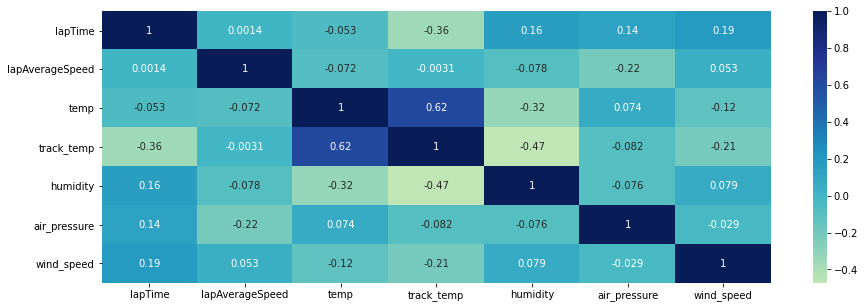

In [11]:
plt.figure(figsize=(15,5))
p = sns.heatmap(data=df.corr(method='spearman'), annot=True, cmap='YlGnBu', center=0)

This information may be more interpretable later on when we develop our models for `lapTime`. On first glance, it seems `air_pressure` is going to have little predictive power, due to its low range in Table 1 and lack of relationship with other features. Additionally, `temp`, `track_temp` and `humidity` are all moderately related.

Now specifically investigating the target features of our report.

In [12]:
df[['lapTime']].describe()

,lapTime
count,215.000000
mean,92600.561456
std,11098.117244
min,72460.200000
25%,83092.395500
50%,92599.222000
75%,100946.418000
max,121779.435000


Range of `lapTime` seems suitable, as does its variance.

### Categorical Features

We can now safely remove the `date` and `weather` columns as `year` sufficiently describes date, and `rain` describes the track conditions.

In [13]:
df = df.drop(columns=['date', 'weather'])

Now lets investigate the categorical features of our dataframe.

In [14]:
categorical_columns = df.columns[df.dtypes=='category'].tolist()
categorical_columns += df.columns[df.dtypes==object].tolist()

for col in categorical_columns:
    print('Unique values for ' + col)
    print(df[col].unique())
    print('')

Unique values for track
[albert-park, sepang, shanghai, sachir, catalunya, ..., montreal, magny-cours, indianapolis, austin, mexico]
Length: 20
Categories (20, object): [albert-park, sepang, shanghai, sachir, ..., magny-cours, indianapolis, austin, mexico]

Unique values for rain
[dry, wet]
Categories (2, object): [dry, wet]

Unique values for year
[2009, 2008, 2007, 2010, 2011, ..., 2015, 2016, 2017, 2018, 2019]
Length: 13
Categories (13, int64): [2009, 2008, 2007, 2010, ..., 2016, 2017, 2018, 2019]

Unique values for wind_direction
['south' 'turning' 'east' 'southeast' 'northeast' 'northwest' 'west'
 'north' 'southern' 'southwest' 'turning east' 'turning south'
 'western liqueur' 'turning west' 'turning southeast' 'changing']



As shown above, the unique values for `wind_direction` are large. Due to a translator function being used in the scrape weather script mentioned earlier, there is some conflicting and similar information being shown. With this in mind, it is likely that this data is not going to aid our models. Therefore, it will be removed.

In [15]:
df = df.drop(columns='wind_direction')

## Statistical Modelling & Performance Evaluation <a name="model">

### Full Model
Below is our current dataframe we will be using to develop our models for predicting `fastestLapSpeed` and `fastestLapTime`.

In [16]:
df.sample(5, random_state=999)

,lapTime,lapAverageSpeed,track,temp,track_temp,humidity,air_pressure,wind_speed,rain,year
148,101203.545,193.917,shanghai,21.0,37.0,37.0,1014.0,4.8,dry,2016
191,84167.789,247.815,monza,22.0,32.0,61.0,995.0,2.5,dry,2018
125,103112.500,192.507,indianapolis,23.0,32.0,42.0,1003.0,6.0,dry,2014
68,91556.087,209.944,istanbul,16.0,33.0,44.0,1001.0,6.0,dry,2011
187,95886.722,219.376,magny-cours,24.0,41.0,52.0,966.0,1.0,dry,2018


Now we can develop our two models. On the X-Axis, we add all of our features and categorical variables. Below are the categorical features that will be converted and first dropped for our model. `year` and `track` are included in the model as performance changes throughout the years due to engine designs among other regulations pertaining to the FIA, and track, as each track requires different car configurations and differs in distance etc.
* `rain` dummy dropped is dry
* `track` dummy dropped is Abu-Dahbi
* `year` dummy dropped is 2007

On the Y-Axis, our target features mentioned earlier, namely `lapTime`.

In [17]:
X = df[['temp', 'track_temp', 'lapAverageSpeed', 'humidity', 'air_pressure', 'wind_speed', 'rain', 'track', 'year']]
Y = df['lapTime']

# Convert categorical into dummy/indicator variables
X = pd.get_dummies(data=X, drop_first=True)

# With sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# With statsmodels
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                lapTime   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     46.70
Date:                Fri, 23 Oct 2020   Prob (F-statistic):           2.11e-73
Time:                        17:38:34   Log-Likelihood:                -2048.6
No. Observations:                 215   AIC:                             4175.
Df Residuals:                     176   BIC:                             4307.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.608e+05   1.22

#### Model Analysis

91% of the variation is explained by the independant variables. Observing the p-values, `temp`, `lapAverageSpeed` and `wind_speed` are all statistically significant at the 5% level, whereas `track_temp`, `humidity`, `air_pressure` and `rain` are not. Most of the `tracks` and `years` are highly significant, bar a few.

Now we produce new dataframes for prediction purposes, and plot residuals for the mull models.

In [18]:
residuals_full = pd.DataFrame({'actual': df['lapTime'], 
                            'predicted': model.fittedvalues, 
                            'residual': model.resid})
residuals_full.sample(5, random_state=999)

,actual,predicted,residual
148,101203.545,103597.588004,-2394.043004
191,84167.789,84807.756397,-639.967397
125,103112.500,102482.073599,630.426401
68,91556.087,92262.273173,-706.186173
187,95886.722,86218.008914,9668.713086


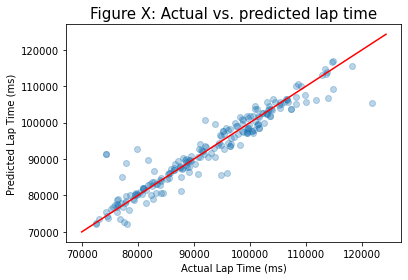

In [19]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Lap Time (ms)');
plt.ylabel('Predicted Lap Time (ms)');
plt.title('Figure X: Actual vs. predicted lap time', fontsize=15);
plt.show();

Looking at Figure X, we can see that the model is quite accurate for most mid-range track fastest laps, but starts to suffer on longer and shorter tracks. An assumption here is that the longer the track time, the larger the total distance of the track.

### Model Diagnostic Checks

This section of the report will analyse assumptions of our regression, and whether or not they are sound. More noteably:
* Linearity of relationship between target variables and independant variables
* Constant variance of errors
* Normality of residual distribution
* Statistical independence of residuals

First, lets produce a scatter plot of residuals for both models.

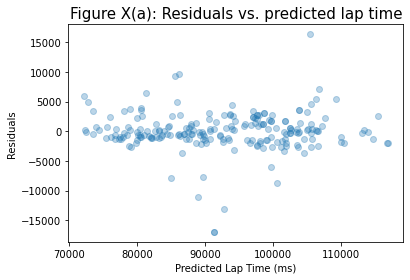

In [20]:
plt.scatter(residuals_full['predicted'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Lap Time (ms)');
plt.ylabel('Residuals')
plt.title('Figure X(a): Residuals vs. predicted lap time', fontsize=15)
plt.show();

Looking at Figure X(a), we can see majority of values centre around 0 and are mostly random. We do not see any evidence of a banding pattern. 

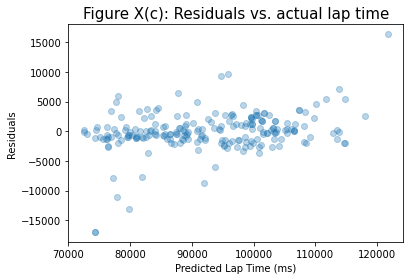

In [21]:
plt.scatter(residuals_full['actual'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Lap Time (ms)');
plt.ylabel('Residuals')
plt.title('Figure X(c): Residuals vs. actual lap time', fontsize=15)
plt.show();

In this particular plot, we see the model underestimating speeds below 80000ms and overestimating about 110000ms.

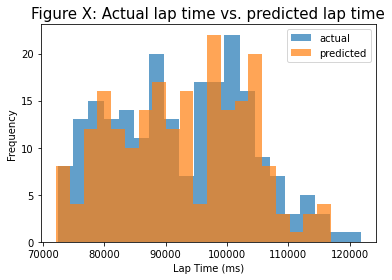

In [22]:
plt.hist(residuals_full['actual'], label='actual', bins=20, alpha=0.7);
plt.hist(residuals_full['predicted'], label='predicted', bins=20, alpha=0.7);
plt.xlabel('Lap Time (ms)');
plt.ylabel('Frequency');
plt.title('Figure X: Actual lap time vs. predicted lap time', fontsize=15);
plt.legend()
plt.show();

Here we can see that for the most part, the models predictions are fairly accurate.

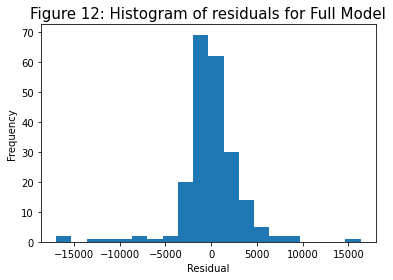

In [23]:
plt.hist(residuals_full['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 12: Histogram of residuals for Full Model', fontsize=15);
plt.show();

Residuals are regularly symmetric. Though slightly right-skewed. However, we can say with confidence that the normality assumption is not violated.

### Backwards Feature Selection

Given the p-value violation (> 0.05) of a few features, namely...
* `track_temp`
* `humidity`
* `air_pressure`
* `rain_wet`

We drop these features, a run a new OLS Regression.

In [24]:
X = df[['temp', 'lapAverageSpeed', 'wind_speed', 'track', 'year']]

# Convert categorical into dummy/indicator variables
X = pd.get_dummies(data=X, drop_first=True)

# With sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# With statsmodels
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                lapTime   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     51.69
Date:                Fri, 23 Oct 2020   Prob (F-statistic):           1.05e-75
Time:                        17:38:35   Log-Likelihood:                -2051.8
No. Observations:                 215   AIC:                             4174.
Df Residuals:                     180   BIC:                             4291.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.675e+05   9060

Similar to what we did with the first model, we will plot residuals etc.

In [25]:
residuals_reduced = pd.DataFrame({'actual': df['lapTime'], 
                            'predicted': model.fittedvalues, 
                            'residual': model.resid})
residuals_reduced.sample(n=5, random_state=999)

,actual,predicted,residual
148,101203.545,103841.529519,-2637.984519
191,84167.789,85118.044226,-950.255226
125,103112.500,102059.796808,1052.703192
68,91556.087,92925.120577,-1369.033577
187,95886.722,86301.760057,9584.961943


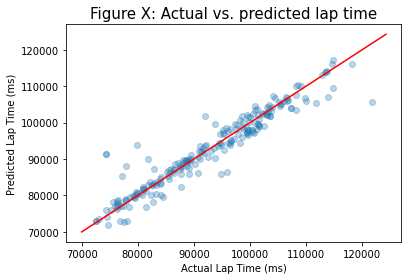

In [26]:
plt.scatter(residuals_reduced['actual'], residuals_reduced['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Lap Time (ms)');
plt.ylabel('Predicted Lap Time (ms)');
plt.title('Figure X: Actual vs. predicted lap time', fontsize=15);
plt.show();

New model gives us an adjusted R-Squared value of 0.89. This means that 89% of the variance of lapTime can be explained with four less variables. However, we are still running into the same problems with the previous model, namely overestimation at shorter tracks and underestimation at longer.

### Reduced Model Diagnostic Checks

As previously, we will generate some scatter plots of residuals as a function of `lapTime`.

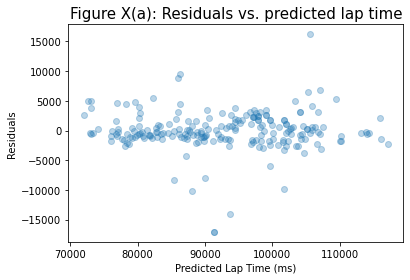

In [27]:
plt.scatter(residuals_reduced['predicted'], residuals_reduced['residual'], alpha=0.3);
plt.xlabel('Predicted Lap Time (ms)');
plt.ylabel('Residuals')
plt.title('Figure X(a): Residuals vs. predicted lap time', fontsize=15)
plt.show();

Results exhibit similar nature to that of initial model. See Figure X(a).

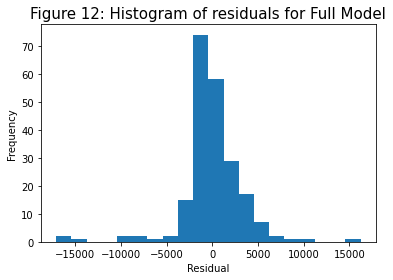

In [28]:
plt.hist(residuals_reduced['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 12: Histogram of residuals for Full Model', fontsize=15);
plt.show();

Very similar again to previous histogram generated in Figure X. Looks relatively symmetric around 0 with similar right-skewdness.

## Summary & Conclusion <a name="conc">

Furthur study. These models are only somewhat reliable for the tracks and conditions mentioned. Furthur studies it is suggested to instead of looking at tracks as a whole, look at track attributes, such as corner types, length etc. This would allow a future model to perform more accurately accross a wider range of tracks and environments, potentially allowing for new track designs to be tested.